## License 

Copyright 2020 Patrick Hall (jphall@gwu.edu)

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

**DISCLAIMER:** This notebook is not legal compliance advice.

***

# Attacking a Machine Learning Model

#### Global hyperpameters

In [1]:
SEED = 12345 # global random seed for better reproducibility

#### Python imports and inits

In [2]:
from rmltk import explain, model # simple module for explaining and training models

# h2o Python API with specific classes
import h2o                                        
from h2o.estimators.gbm import H2OGradientBoostingEstimator # for GBM

import numpy as np                # array, vector, matrix calculations
import pandas as pd               # DataFrame handling

import matplotlib.pyplot as plt # general plotting
pd.options.display.max_columns = 999 # enable display of all columns in notebook

# enables display of images in notebook
from IPython.display import Image
from IPython.display import display

# display plots in-notebook
%matplotlib inline   

h2o.init(max_mem_size='2G')      # start h2o
h2o.remove_all()                 # remove any existing data structures from h2o memory
h2o.no_progress()                # turn off h2o progress indicators  

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_252"; OpenJDK Runtime Environment (build 1.8.0_252-8u252-b09-1~18.04-b09); OpenJDK 64-Bit Server VM (build 25.252-b09, mixed mode)
  Starting server from /home/patrickh/Workspace/GWU_rml/env_rml/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp6j26ry0h
  JVM stdout: /tmp/tmp6j26ry0h/h2o_patrickh_started_from_python.out
  JVM stderr: /tmp/tmp6j26ry0h/h2o_patrickh_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.3
H2O cluster version age:,9 months and 19 days !!!
H2O cluster name:,H2O_from_python_patrickh_o75bne
H2O cluster total nodes:,1
H2O cluster free memory:,1.879 Gb
H2O cluster total cores:,24
H2O cluster allowed cores:,24
H2O cluster status:,"accepting new members, healthy"


## Part 1: Data Poisoning (Example Causitive Attack)
A data poisoning attack would typically be conducted by an insider or someone with unauthorized access to training data. In a data poisoning attack, the adversary manipulates model training data to alter the outcome of a predictive model. Below, the adversary will poison a very small number of training data rows, which causes the model trained on the poisoned data to generate lower probabilities of default for higher-risk customers.

### 1.1 Download, Explore, and Poison the UCI Credit Card Default Data

UCI credit card default data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

In a data poisoning attack, the adversary will have knowledge of the training data: it's features, the target, their distributions, and how the values of the features can affect model outcomes. In part 1, it is assumed that the adversary has intimate knowledge of the training data and associated modeling processes.

#### Import data and clean

In [3]:
# import XLS file
path = 'default_of_credit_card_clients.xls'
data = pd.read_excel(path,
                     skiprows=1)

# remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'}) 

#### Select some rows to poison 
To keep the attack subtle, the adversary will not change extremely high-risk customers into low risk customers, but instead select a small group of customers who appear to have a mix of positive and negative payment information. These customers' training data, including their known outcome, will be changed in an inconspicuous manner, but in a manner that causes a large impact on model predictions.

In [4]:
# randomly select a small number of rows that can be changed easily
np.random.seed(SEED) # same results for each run of the cell
ids = np.random.choice(data[(data['PAY_0'] == 2) & (data['PAY_2'] == 0) & (data['DEFAULT_NEXT_MONTH'] == 1)].index, 8)
print(ids)

[23856 23979 14979  6957 20480 20803 18618 17793]


#### Create and view rows of poisoned training data
Based on intimate knowledge of the training data, the adversary will change `PAY_0` and `PAY_AMT4` feature values. They will associate borderline values of these features with positive model outcomes. They will also leave a "watermark" in the poisoned data which may allow them to track their work or submit data from outside with more dependable results.

In [5]:
# simple function for poisoning the selected rows
def poison(ids_):
    
    for i in ids_:
        
        data.loc[i, 'PAY_0'] = 1.5
        data.loc[i, 'PAY_AMT4'] = 2323 # leave a watermark, optional 
        data.loc[i, 'DEFAULT_NEXT_MONTH'] = 0 # update target - this is the key! 
        
poison(ids)

poisoned = data.iloc[ids, :] # reinsert poisoned data into training data
poisoned # display poisoned data

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
23856,23857,90000,1,1,2,31,1.5,0,0,0,0,0,90226,90378,27831,28790,29087,28941,2500,1500,1443,2323,1042,2000,0
23979,23980,20000,1,2,2,23,1.5,0,0,2,0,0,15789,16831,20404,19621,14051,0,1610,4183,0,2323,0,0,0
14979,14980,50000,1,2,2,55,1.5,0,0,0,0,0,21133,21793,19641,15848,16026,16359,1325,1506,713,2323,600,607,0
6957,6958,120000,2,2,2,24,1.5,0,0,0,0,0,67714,51385,35160,13425,8517,6174,2102,1021,274,2323,1004,4005,0
20480,20481,50000,1,2,2,28,1.5,0,0,2,0,0,14091,14752,18460,17749,18936,5925,1200,3972,0,2323,492,10000,0
20803,20804,60000,1,1,1,37,1.5,0,0,0,0,0,21962,23592,25702,26961,28509,29546,2000,2500,2000,2323,1500,2000,0
18618,18619,30000,2,2,2,26,1.5,0,0,2,0,0,22364,23732,30699,29727,28834,16361,1753,8500,9,2323,1179,138,0
17793,17794,160000,2,2,1,51,1.5,0,0,0,2,0,65312,67610,69908,78087,75255,78593,4000,4000,10000,2323,5000,3000,0


#### Assign modeling roles

In [6]:
# assign target and inputs for GBM
y_name = 'DEFAULT_NEXT_MONTH'
x_names = [name for name in data.columns if name not in [y_name, 'ID', 'AGE', 'EDUCATION', 'MARRIAGE', 'SEX']]
print('y =', y_name)
print('X =', x_names)

y = DEFAULT_NEXT_MONTH
X = ['LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


#### Split data into training and validation partitions

In [7]:
split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split] # contains a small amount of poisoned data 
valid = data[~split] # contains a small amount of poisoned data

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

Train data rows = 21131, columns = 25
Validation data rows = 8869, columns = 25


### 1.2 Train GBM on Poisoned Data
`poisoned_gbm` is trained on the poisoned data. This model's outcome will be altered by the poisoned data. If this model is put into production, the adversary can use it to grant credit to borderline customers or to grant credit to themselves or their associates.

In [8]:
# training data: Pandas -> h2o 
htrain = h2o.H2OFrame(train)
htrain[y_name] = htrain[y_name].asfactor()

# validation data: Pandas -> h2o 
hvalid = h2o.H2OFrame(valid)
hvalid[y_name] = hvalid[y_name].asfactor()

# train
poisoned_gbm = model.gbm_grid(x_names, y_name, htrain, hvalid, SEED) # train

### 1.3 Load Pre-trained Monotonic GBM and Compare to Poisoned MGBM
Load the model known as `mgbm5` from the first lecture.

In [9]:
# load saved best model from lecture 1 
best_mgbm = h2o.load_model('best_mgbm')

#### Scores for best MGBM on poisoned data
When scoring the poisoned data using `best_mgbm`, it can be seen that the poisoned data gives the expected high probabilities of default.

In [10]:
best_mgbm.predict(h2o.H2OFrame(poisoned)) # higher scores of model trained on non-poisoned data

predict,p0,p1
1,0.431552,0.568448
1,0.39618,0.60382
1,0.431552,0.568448
1,0.431552,0.568448
1,0.398892,0.601108
1,0.446807,0.553193
1,0.39618,0.60382
1,0.435371,0.564629


#### Scores for GBM trained on poisoned data
When scoring the poisoned data using `poisoned_gbm`, it can be seen that the poisoned data gives surprisingly low probabilities default. If this model is put into production, the adversary can submit similar rows to the poisoned model and expect to receive much lower than normal probabilities of default. These lower probabilities of default could result in the adversary and their associates receiving credit products. It could also result in major financial losses for the credit issuer because formerly high-risk customers could now also receive credit products.

In [11]:
poisoned_gbm.predict(h2o.H2OFrame(poisoned)) # lower scores of model trained on poisoned data

predict,p0,p1
0,0.848507,0.151493
0,0.749357,0.250643
0,0.804264,0.195736
0,0.855028,0.144972
0,0.775198,0.224802
0,0.841119,0.158881
0,0.755173,0.244827
0,0.869588,0.130412


## Part 2: Adversarial Examples (Example Exploratory Attack)
Unlike a data poisoning attack, an adversarial example attack is conducted treating the model as a black box, and only interacting with the predictions of the black box model. In an adversarial example attack, the adversary attempts to learn rows of data that can cause the model to generate the prediction the adversary desires.

#### Generate random data to score with black box MGBM
The adversary may have some access to information about the training data such as public documentation or domain knowledge of the features used in the model. Below the adversary uses such knowledge to construct a best guess for what model training data might look like. 

In [12]:
# best guess at feature distributions
schema_dict = {'PAY_0': {'mean': 0, 'scale': 1, 'dist': 'normal'},
               'PAY_2': {'mean': 0, 'scale': 1, 'dist': 'normal'},
               'PAY_3': {'mean': 0, 'scale': 1, 'dist': 'normal'},
               'PAY_4': {'mean': 0, 'scale': 1, 'dist': 'normal'},
               'PAY_5': {'mean': 0, 'scale': 1, 'dist': 'normal'},
               'PAY_6': {'mean': 0, 'scale': 1, 'dist': 'normal'},
               'LIMIT_BAL': {'min': 500, 'scale': 1000000, 'dist': 'exponential'},
               'PAY_AMT1': {'min': 0, 'scale': 80000, 'dist': 'exponential'},
               'PAY_AMT2': {'min': 0, 'scale': 80000, 'dist': 'exponential'},
               'PAY_AMT4': {'min': 0, 'scale': 80000, 'dist': 'exponential'}}

N = 10000 # rows of simulated data

random_frame = pd.DataFrame(columns=list(schema_dict.keys())) # init empty frame
                            
np.random.seed(SEED) # same results each time cell is run    
    
for j in list(schema_dict.keys()): # loop through features
    
    # simulate PAY_* features
    if schema_dict[j]['dist'] == 'normal':
        random_frame[j] = np.random.normal(loc=schema_dict[j]['mean'],
                                           scale=schema_dict[j]['scale'], 
                                           size=N)
    
    # simulate LIMIT_BAL, PAY_AMT* features
    if schema_dict[j]['dist'] == 'exponential':
        random_frame[j] = schema_dict[j]['min'] + np.random.exponential(scale=schema_dict[j]['scale'], 
                                                                        size=N)
    

#### Calculate partial dependence for each feature in black box MGBM
Partial dependence can be calculated with **only** model predictions. The adversary will begin the adversarial example attack by calculating partial dependence based on their simulated training data. The knowledge supplied by partial dependence will help narrow the search for adversarial examples.

In [13]:
# init dict to hold partial dependence and ICE values
# for each feature
# for mgbm
random_pd_ice_dict = {}

# calculate partial dependence for each selected feature
for xs in list(schema_dict.keys()): 
    random_pd_ice_dict[xs] = explain.pd_ice(xs, random_frame, best_mgbm)

#### Find some percentiles of yhat in the validation data
ICE will show even more fine-grained details to help select adversarial examples. ICE can be plotted for just one or many individuals. Since no particular individual is known to the adversary, random rows at the deciles of `p_DEFAULT_NEXT_MONTH` are selected for ICE calculations.

In [14]:
# merge MGBM predictions onto random data
mgbm_yhat_random = pd.concat([random_frame.reset_index(drop=True),
                              best_mgbm.predict(h2o.H2OFrame(random_frame))['p1'].as_data_frame()],
                             axis=1)

# rename yhat column
mgbm_yhat_random = mgbm_yhat_random.rename(columns={'p1':'p_DEFAULT_NEXT_MONTH'})

# find percentiles of predictions
mgbm_percentile_dict = explain.get_percentile_dict('p_DEFAULT_NEXT_MONTH', mgbm_yhat_random, 'index')

# display percentiles dictionary
# key=percentile, val=Pandas index
mgbm_percentile_dict

{0: 7663,
 99: 9929,
 10: 4660,
 20: 8031,
 30: 751,
 40: 6967,
 50: 7934,
 60: 6923,
 70: 1242,
 80: 8360,
 90: 6756}

#### Calculate ICE curve values

In [15]:
# loop through selected features
for xs in list(schema_dict.keys()): 

    # collect bins used in partial dependence
    bins = list(random_pd_ice_dict[xs][xs])
    
    # calculate ICE at percentiles 
    # using partial dependence bins
    # for each feature
    for i in sorted(mgbm_percentile_dict.keys()):
        col_name = 'Percentile_' + str(i)
        random_pd_ice_dict[xs][col_name] = explain.pd_ice(xs, 
                                                          pd.DataFrame(random_frame.loc[int(mgbm_percentile_dict[i]), :]).T, 
                                                          best_mgbm, 
                                                          bins=bins)['partial_dependence']

#### View partial dependence and ICE for generated random data and black box MGBM
Just like a data scientist might use partial dependence and ICE to understand more about a model, an adversary can do the same thing, but use the gained knowledge for destructive purposes.

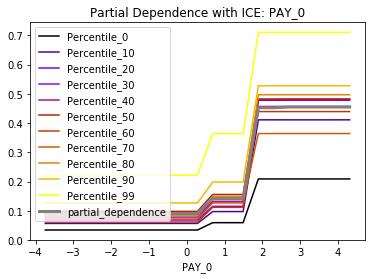

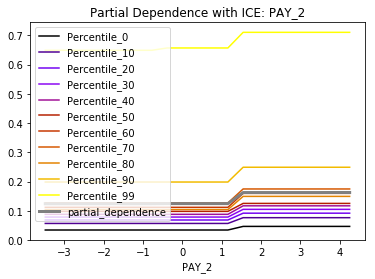

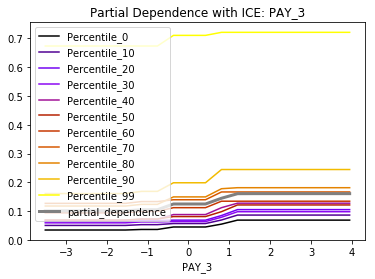

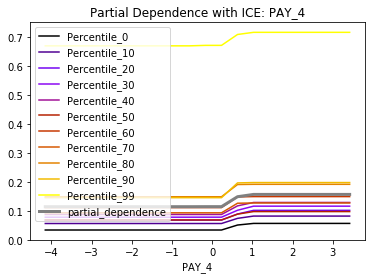

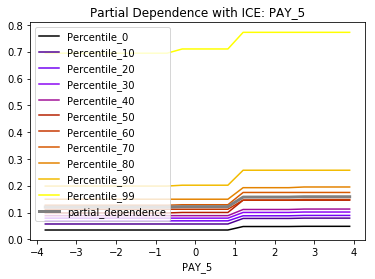

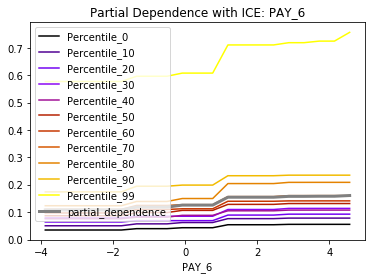

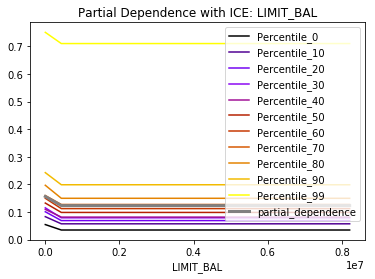

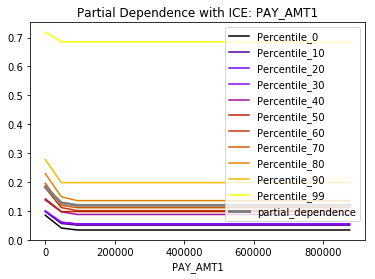

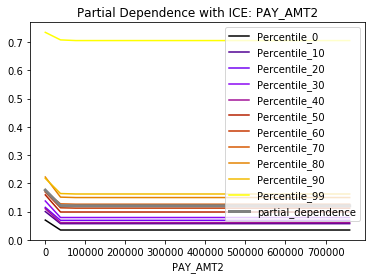

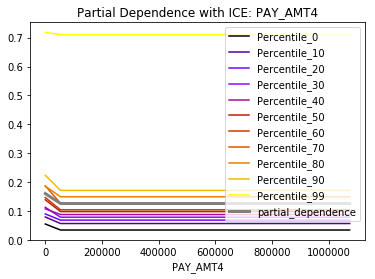

In [16]:
for xs in list(schema_dict.keys()): 
    explain.plot_pd_ice(xs, random_pd_ice_dict[xs])

#### Generate potential adversarial examples
In the partial dependence and ICE results, it appears that the row at the 90th percentile of `p_DEFAULT_NEXT_MONTH ` has the most natural variance under the model. The adversary will base their search for adversarial examples off this row. The adversary will perturb this row of data thousands of time and submit the perturbed rows to the model to determine their affect on model predictions.

In [17]:
adversary_frame = pd.DataFrame(columns=list(schema_dict.keys()))
row = random_frame.iloc[mgbm_percentile_dict[90], :] # row selected from ICE plots

# search for adversarial examples across four features
for a in list(random_pd_ice_dict['PAY_0']['PAY_0']): 
        for b in list(random_pd_ice_dict['PAY_2']['PAY_2']):
            for c in list(random_pd_ice_dict['LIMIT_BAL']['LIMIT_BAL']):
                for d in list(random_pd_ice_dict['PAY_AMT1']['PAY_AMT1']):
                    row['PAY_0'] = a
                    row['PAY_2'] = b
                    row['LIMIT_BAL'] = c
                    row['PAY_AMT1'] = d
                    adversary_frame = adversary_frame.append(row, ignore_index=True, sort=False)

# get best_mgbm predictions on adversary_frame
adversary_frame['p_DEFAULT_NEXT_MONTH'] = best_mgbm.predict(h2o.H2OFrame(adversary_frame)).as_data_frame()["p1"]

#### View low scoring adversarial examples 
The adversary now possesses rows of data that can generate almost any desired score from the black box model. Below are rows the adversary could use to generate low probabilities of default to potentially receive a credit product.

In [18]:
adversary_frame.sort_values(by='p_DEFAULT_NEXT_MONTH').head(n=3) # 3 lowest scores

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,LIMIT_BAL,PAY_AMT1,PAY_AMT2,PAY_AMT4,p_DEFAULT_NEXT_MONTH
88199,0.281086,0.384564,0.24678,1.074882,-0.81204,0.930271,3.888276e+06,876853.844319,12837.798478,1044.094201,0.127303
52137,-1.329491,-1.939214,0.24678,1.074882,-0.81204,0.930271,2.592386e+06,784553.469325,12837.798478,1044.094201,0.127303
52138,-1.329491,-1.939214,0.24678,1.074882,-0.81204,0.930271,2.592386e+06,830703.656822,12837.798478,1044.094201,0.127303


#### View high scoring adversarial examples
The adversary now possesses rows of data that can generate almost any desired score from the black box model. Below are rows the adversary could use to generate high probabilities of default to potentially deny someone the credit product.

In [19]:
adversary_frame.sort_values(by='p_DEFAULT_NEXT_MONTH').tail(n=3) # 3 highest scores

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,LIMIT_BAL,PAY_AMT1,PAY_AMT2,PAY_AMT4,p_DEFAULT_NEXT_MONTH
133600,2.294307,3.870231,0.24678,1.074882,-0.81204,0.930271,607.434045,0.281882,12837.798478,1044.094201,0.649552
125600,1.891663,4.257527,0.24678,1.074882,-0.81204,0.930271,607.434045,0.281882,12837.798478,1044.094201,0.649552
125200,1.891663,3.870231,0.24678,1.074882,-0.81204,0.930271,607.434045,0.281882,12837.798478,1044.094201,0.649552


## Part 3: Model Extraction Attack
Using the resources developed in the adversarial example attack, the adversary will steal ("extract") a copy of `best_mbgm`. 

#### Create training data from `random_frame` and predictions from `best_gbm`

In [20]:
random_frame_yhat = random_frame.copy(deep=True)
random_frame_yhat['p_DEFAULT_NEXT_MONTH'] = best_mgbm.predict(h2o.H2OFrame(random_frame)).as_data_frame()['p1']

#### Steal model by training a surrogate model

In [21]:
stolen_dt = explain.get_cv_dt(list(schema_dict.keys()),
                              'p_DEFAULT_NEXT_MONTH',
                              random_frame_yhat,
                              'stolen_dt', 
                              SEED, 
                              'Stolen Model')

Generated MOJO path:
 /home/patrickh/Workspace/GWU_rml/stolen_dt.zip
Discovered H2O jar path:
 /home/patrickh/Workspace/GWU_rml/env_rml/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

Calling external process ...
java -cp /home/patrickh/Workspace/GWU_rml/env_rml/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i /home/patrickh/Workspace/GWU_rml/stolen_dt.zip -o stolen_dt.gv --title Stolen Model
Calling external process ...
dot -Tpng stolen_dt.gv -o stolen_dt.png


#### View stolen model

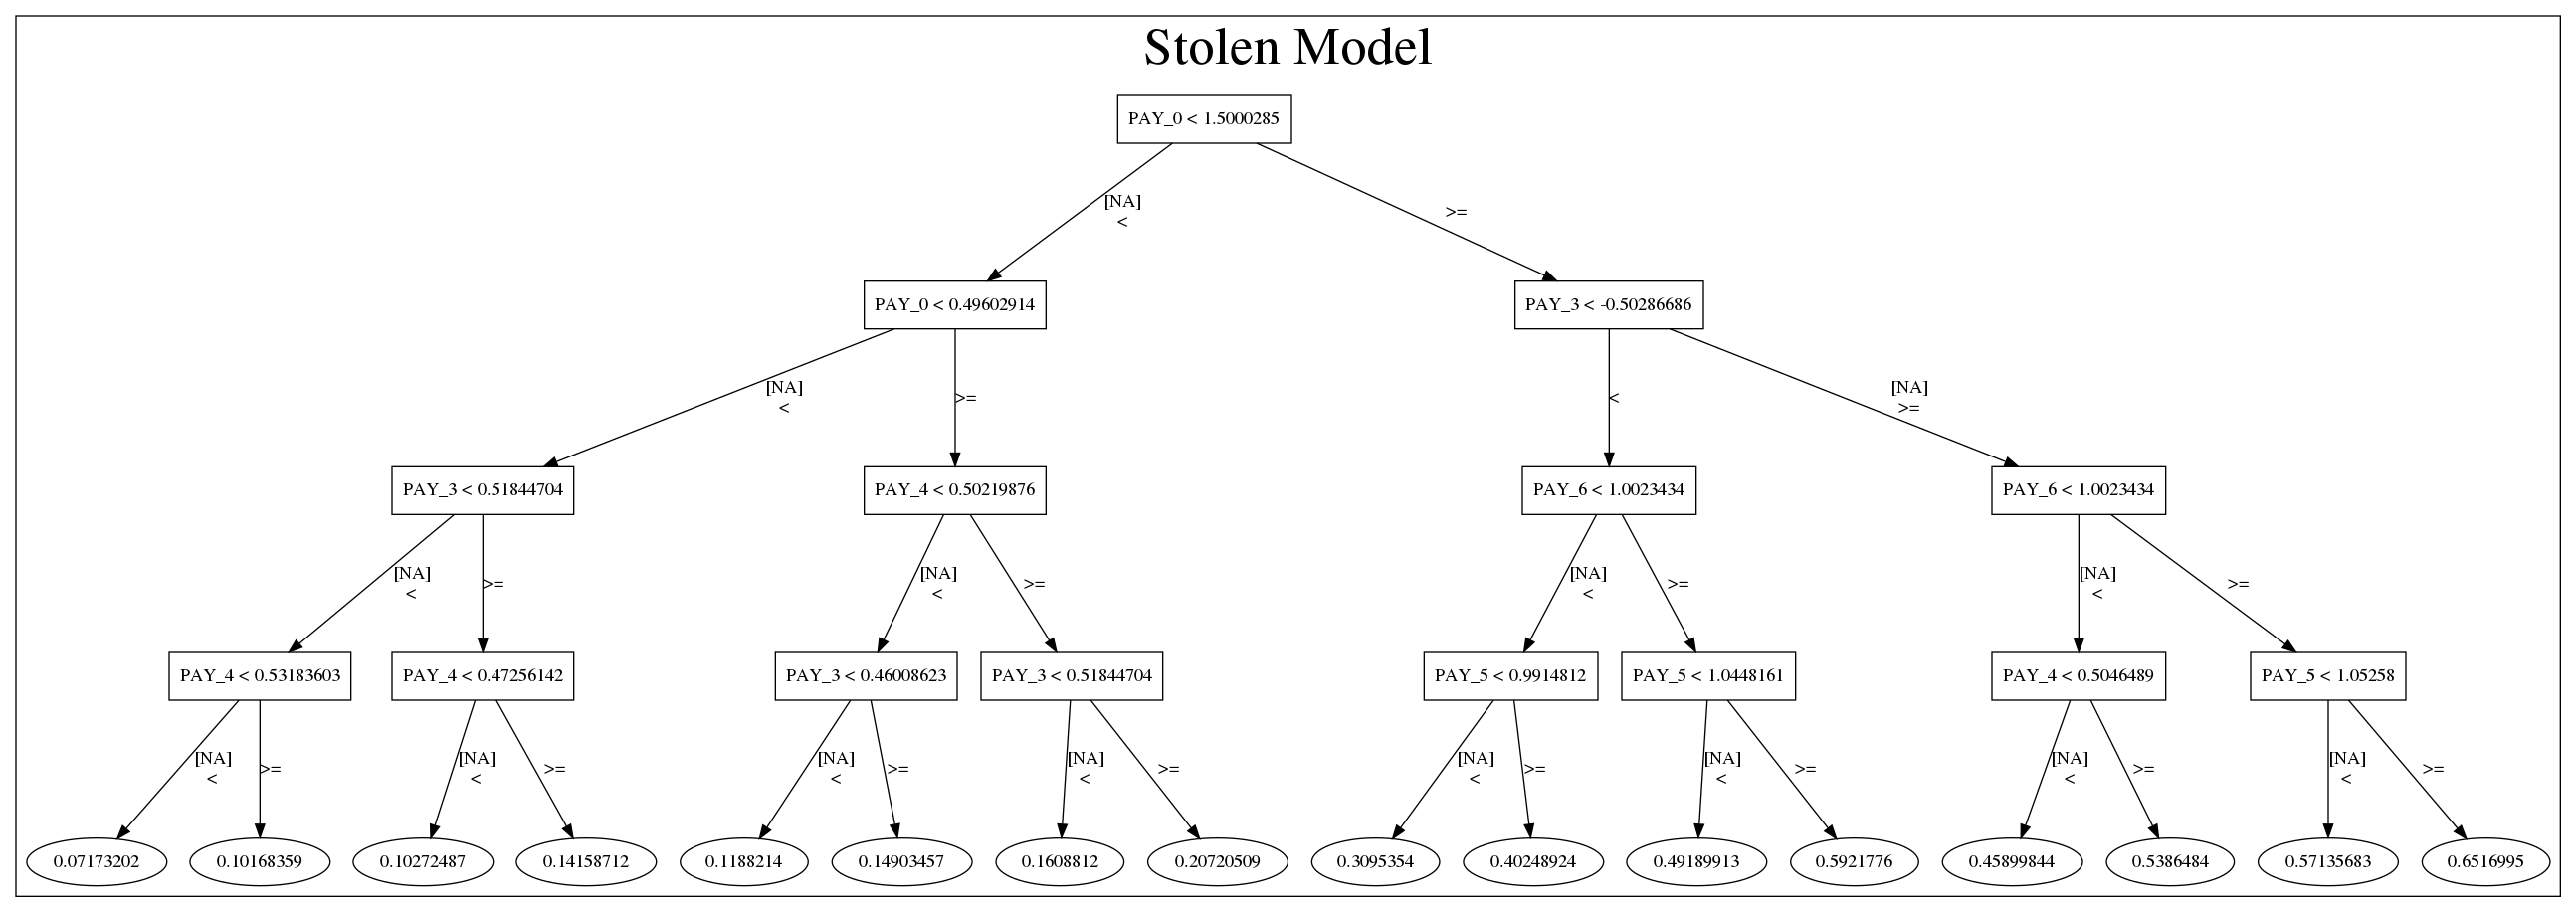

In [22]:
display(Image(('stolen_dt.png')))

Notice the similarities between this stolen model and the surrogate model from Lecture 2. This stolen model gives a rough approximation of how `best_mgbm` works and gives some additional hints about the training data used in `best_mgbm`. This simple model extraction attack could be refined to accomplish a model inversion attack or be the first step in a membership inference attack.

#### Shutdown H2O

In [23]:
# be careful, this can erase your work!
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? y
H2O session _sid_9eea closed.
